In [1]:
import numpy as np
import pandas as pd

from os import walk
from os import listdir

In [2]:
raw_data_path = "../lataus/data/lam"
years = listdir(raw_data_path)

if len(years) < 1:
    print(f"No data folders found in path {raw_data_path}")
else:
    print(f"Available years {', '.join(years)}.")

Available years 2016, 2017.


In [3]:
selected_year = "2016"

elys = listdir(f"{raw_data_path}/{selected_year}")

if len(elys) < 1:
    print(f"No data folders found in path {raw_data_path}")
else:
    print(f"Available elys {', '.join(elys)}.")

Available elys 01, 02, 03, 04, 08, 09, 12, 14.


In [116]:
selected_ely = "01"

lam_data_files = listdir(f"{raw_data_path}/{selected_year}/{selected_ely}")
lam_ids = set()

for filename in lam_data_files:
    lam_ids.add(filename.split("_")[-1].split(".")[0])

if len(lam_ids) < 1:
    print(f"No data folders found in path {raw_data_path}")
else:
    print(f"Available lam ids {', '.join(sorted(lam_ids))}.")

Available lam ids 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 4, 5, 6, 7, 8, 9.


In [5]:
selected_lam = "1"

files = []

for filename in lam_data_files:
    if filename.split("_")[1] == selected_lam:
        files.append(filename)

print(f"{len(files)} file(s) found for lam id {selected_lam}.")

31 file(s) found for lam id 1.


In [6]:
# Start reading files
COLUMN_NAMES = ["pistetunnus", "vuosi", "päivän järjestysnumero", "tunti", "minuutti", "sekunti", "sadasosasekunti", "pituus (m)", "kaista", "suunta", "ajoneuvoluokka", "nopeus (km/h)", "faulty", "kokonaisaika", "aikaväli", "jonoalku"]
CARGO_IDS = [2,4,5]
CAR_IDS = [1,3,6]

In [7]:
df = pd.read_csv(f"{raw_data_path}/{selected_year}/{selected_ely}/{files[0]}", sep=";", names=COLUMN_NAMES)

In [8]:
df["time_index"] = df["tunti"] * 60 + df["minuutti"]
df = df.drop(["tunti", "minuutti", "sekunti", "sadasosasekunti"], axis=1)

In [9]:
df = df.drop(["kokonaisaika", "aikaväli", "jonoalku", "kaista"], axis=1)

In [10]:
def create_bin_definition(minute_interval):
    return np.arange(0, 24 * 60, minute_interval)

In [11]:
bins =  create_bin_definition(5)
ind = np.digitize(df["time_index"], bins)

In [16]:
def process_data(data, i):
    direction_1 = data.loc[data["suunta"] == 1]
    direction_2 = data.loc[data["suunta"] == 2]
    
    cargo_cols_1 = process_car_type(direction_1, [2,4,5])
    car_cols_1 = process_car_type(direction_1, [1,3,6])
    cargo_cols_2 = process_car_type(direction_2, [2,4,5])
    car_cols_2 = process_car_type(direction_2, [1,3,6])
    
    return ([i, 1] + cargo_cols_1 + car_cols_1, [i, 2] + cargo_cols_2 + car_cols_2)

def process_car_type(data, car_types):
    CAR_IDS = [1,3,6]
    car_type_data = data[data['ajoneuvoluokka'].isin(car_types)]
    speeds = calculate_speed_data(car_type_data["nopeus (km/h)"])
    count = len(car_type_data)
    
    return speeds + [count]
    
def calculate_speed_data(speed_col):
    if len(speed_col) == 0:
        return [0, 0, 0]
    max_v = speed_col.max()
    min_v = speed_col.min()
    mean_v = round(speed_col.mean())
    return [max_v, min_v, mean_v]
    

In [65]:
processed_rows = []

for bin_index in set(ind):
    # Process the bin
    processed = process_data(df.loc[ind == bin_index], bin_index)
    processed_rows.append(processed[0])
    processed_rows.append(processed[1])
    
processed_np = np.array(processed_rows)

In [66]:
processed_col_names = ["time_index", "direction", "cargo_min_v", "cargo_max_v", "cargo_mean_v", "cargo_count", "car_min_v", "car_max_v", "car_mean_v", "car_count"]

In [67]:
def preprocess_col(a, min_value, max_value, col_name):
    processed_col_names = ["time_index", "direction", "cargo_min_v", "cargo_max_v", "cargo_mean_v", "cargo_count", "car_min_v", "car_max_v", "car_mean_v", "car_count"]    
    col_index = processed_col_names.index(col_name)
    a[a[:, col_index] >= max_value, col_index] = max_value
    a[a[:, col_index] < min_value, col_index] = min_value
    a[:, col_index] = a[:, col_index] - min_value
    return a

In [68]:
speed_cols = ["cargo_min_v", "cargo_max_v", "cargo_mean_v", "car_min_v", "car_max_v", "car_mean_v"]
min_speed = 20
max_speed = 140

for col in speed_cols:
    processed_np = preprocess_col(processed_np, min_speed, max_speed, col)

In [69]:
processed_np[:, 2:5] = processed_np[:, 2:5] / (max_speed - min_speed) * 256
processed_np[:, 7:10] = processed_np[:, 7:10] / (max_speed - min_speed) * 256

In [98]:
def create_columns(a, column_name):
    processed_col_names = ["time_index", "direction", "cargo_min_v", "cargo_max_v", "cargo_mean_v", "cargo_count", "car_min_v", "car_max_v", "car_mean_v", "car_count"]    
    col_index = processed_col_names.index(column_name)
    
    dir_1 = a[a[:, 1] == 1]
    dir_2 = a[a[:, 1] == 2]
    col_1 = dir_1[:, col_index]
    col_2 = dir_2[:, col_index]
    
    result = np.column_stack((col_1, col_2))
    
    return result

In [113]:
car_count_matrix = create_columns(processed_np, "car_min_v")
car_count_matrix[0:5]

array([[108,  86],
       [ 92, 104],
       [ 89,  91],
       [ 91, 107],
       [ 76,  90]], dtype=int64)

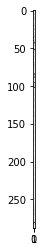

In [114]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig = plt.figure()
ax1 = fig.add_subplot(121)

# 'nearest' interpolation - faithful but blocky
ax1.imshow(car_count_matrix, cmap=cm.Greys_r)

plt.show()

In [117]:
ind

array([  1,   1,   1, ..., 288, 288, 288], dtype=int64)

In [118]:
bins

array([   0,    5,   10,   15,   20,   25,   30,   35,   40,   45,   50,
         55,   60,   65,   70,   75,   80,   85,   90,   95,  100,  105,
        110,  115,  120,  125,  130,  135,  140,  145,  150,  155,  160,
        165,  170,  175,  180,  185,  190,  195,  200,  205,  210,  215,
        220,  225,  230,  235,  240,  245,  250,  255,  260,  265,  270,
        275,  280,  285,  290,  295,  300,  305,  310,  315,  320,  325,
        330,  335,  340,  345,  350,  355,  360,  365,  370,  375,  380,
        385,  390,  395,  400,  405,  410,  415,  420,  425,  430,  435,
        440,  445,  450,  455,  460,  465,  470,  475,  480,  485,  490,
        495,  500,  505,  510,  515,  520,  525,  530,  535,  540,  545,
        550,  555,  560,  565,  570,  575,  580,  585,  590,  595,  600,
        605,  610,  615,  620,  625,  630,  635,  640,  645,  650,  655,
        660,  665,  670,  675,  680,  685,  690,  695,  700,  705,  710,
        715,  720,  725,  730,  735,  740,  745,  7

In [119]:
len(bins)

288

In [122]:
set(ind).index(1)

AttributeError: 'set' object has no attribute 'index'